In [1]:
!pip install openpyxl

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 250.9/250.9 kB 4.3 MB/s eta 0:00:00


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
import string
import re

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, LSTM
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [3]:
# load data exclude Columna1
df_news = pd.read_excel('data/Noticias.xlsx', usecols='B:F')
df_news.shape

(14396, 5)

In [4]:
df_news.head(2)

,Enlaces,Título,info,contenido,Etiqueta
0,https://www.eltiempo.com/agresion-contra-un-op...,Operador de grúa quedó inconsciente tras agres...,El conductor de una moto le lanzó el casco y p...,Las autoridades están buscando al conductor de...,colombia
1,https://www.eltiempo.com/archivo/documento/CMS...,"Usaquén, primera en infracciones por mal parqueo",La localidad ocupa el primer lugar en comparen...,"""Los andenes son para los peatones"", reclama e...",archivo


In [5]:
df_news.describe()

,Enlaces,Título,info,contenido,Etiqueta
count,14396,14378,11483,13738,14396
unique,14396,13851,11412,13202,26
top,https://www.eltiempo.com/vida/viajar/yovoy-cam...,Caricaturas,"Si no tuvo tiempo para informarse hoy, aquí un...",Manizales 10:00 p.m. Ya se venden medicamentos...,archivo
freq,1,138,12,238,9187


# Exercise 1
Data exploration

In [6]:
category_counts = df_news['Etiqueta'].value_counts()
print(category_counts[:15])

Etiqueta
archivo                9187
colombia                934
deportes                727
opinion                 532
mundo                   446
cultura                 430
economia                367
justicia                343
bogota                  311
vida                    268
politica                252
tecnosfera              214
salud                   106
historias-el-tiempo      57
mundial                  47
Name: count, dtype: int64


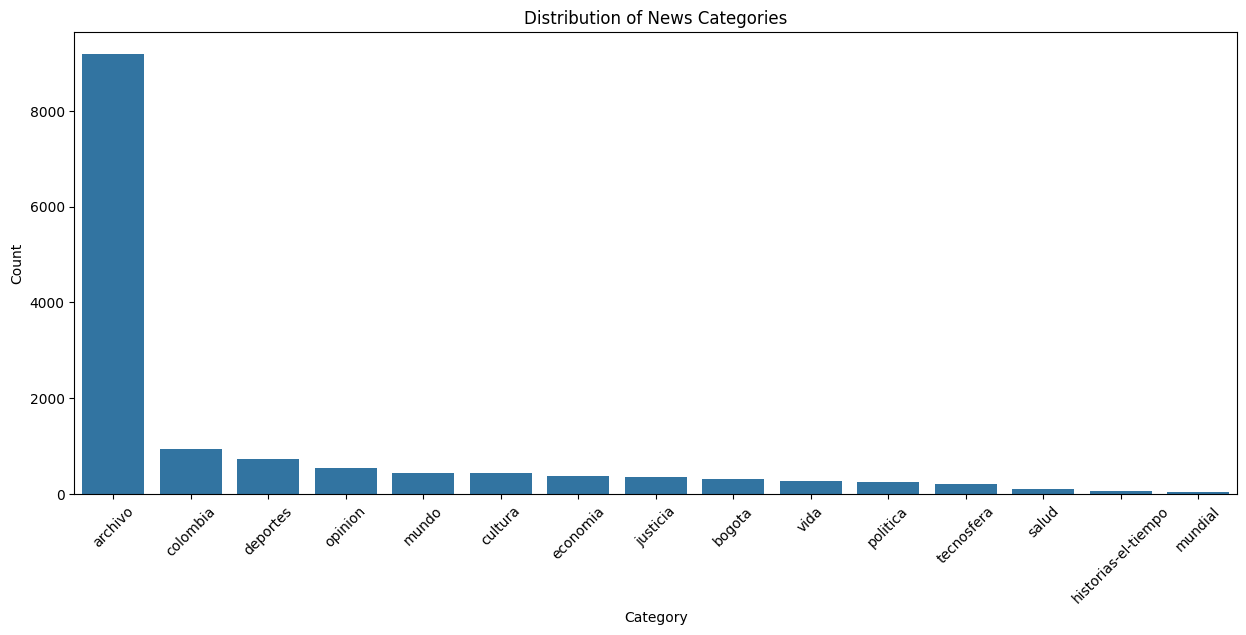

In [7]:
plt.figure(figsize=(15,6))
sns.barplot(x=category_counts.index[:15], y=category_counts.values[:15])
plt.title('Distribution of News Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

# Exercise 2
Filter by most relevant

In [9]:
# randomly picked 100 as the min threshold
most_relevant_cats = category_counts[(category_counts > 100) & (category_counts < 1000)]
print(most_relevant_cats)

Etiqueta
colombia      934
deportes      727
opinion       532
mundo         446
cultura       430
economia      367
justicia      343
bogota        311
vida          268
politica      252
tecnosfera    214
salud         106
Name: count, dtype: int64


In [10]:
df_filtered = df_news[df_news['Etiqueta'].isin([
    'deportes',
    'opinion',
    'cultura',
    'economia',
    'justicia',
    'politica',
    'tecnosfera',
    'salud'
])]
df_filtered.shape

(2971, 5)

# Exercise 3
Data preprocessing

In [11]:
df_preprocessed = df_filtered.copy()
df_preprocessed.shape

(2971, 5)

In [12]:
df_preprocessed = df_preprocessed[['Título', 'info', 'contenido', 'Etiqueta']]
df_preprocessed.shape

(2971, 4)

In [13]:
df_preprocessed = df_preprocessed.dropna()
df_preprocessed.shape

(2388, 4)

In [14]:
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta
10487,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura
10488,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura


In [15]:
df_preprocessed['unified_text'] = 'Título: ' + df_preprocessed['Título'] + '. Resumen: ' + df_preprocessed['info'] + '. Contenido: ' + df_preprocessed['contenido'] + '.'
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta,unified_text
10487,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura,"Título: Al interior de, aparte, roquero, rock ..."
10488,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura,Título: Antonina Canal: 20 años de danza orien...


In [16]:
def preprocess_text(text):
    stripped = text.strip()
    cleaned = re.sub(r'[\n\t]+', ' ', stripped)
    cleaned = re.sub(r'\s{2,}', ' ', cleaned)
    cleaned = re.sub(r'\.{2,}', '.', cleaned)
    return cleaned

In [17]:
df_preprocessed['cleaned_text'] = df_preprocessed['unified_text'].apply(preprocess_text)
df_preprocessed.head(2)

,Título,info,contenido,Etiqueta,unified_text,cleaned_text
10487,"Al interior de, aparte, roquero, rock / El len...",'Al interior de' es el reemplazo sofisticado e...,Citas: “Los crímenes de violencia sexual comet...,cultura,"Título: Al interior de, aparte, roquero, rock ...","Título: Al interior de, aparte, roquero, rock ..."
10488,Antonina Canal: 20 años de danza oriental en C...,La bailarina habló con EL TIEMPO de su trayect...,Con motivo de la celebración de los 20 años de...,cultura,Título: Antonina Canal: 20 años de danza orien...,Título: Antonina Canal: 20 años de danza orien...


In [18]:
# oov token is used to replace the words which are not in the vocabulary (Out Of Vocabulary)
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df_preprocessed['cleaned_text'])
word_index = tokenizer.word_index
print('Number of unique words:', len(word_index))
print('First 10 words:', dict(list(word_index.items())[:10]))

Number of unique words: 66222
First 10 words: {'<OOV>': 1, 'de': 2, 'la': 3, 'en': 4, 'el': 5, 'que': 6, 'y': 7, 'a': 8, 'del': 9, 'los': 10}


In [19]:
sequences = tokenizer.texts_to_sequences(df_preprocessed['cleaned_text'])
max_length = max([len(seq) for seq in sequences])
X = pad_sequences(sequences, maxlen=max_length, padding='post')
cats = df_preprocessed['Etiqueta'].astype('category').cat
y = cats.codes.values
encoded_category = dict(enumerate(cats.categories))

# Exercise 4
Data split

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

print("Training set size:", X_train.shape, y_train.shape)
print("Validation set size:", X_val.shape, y_val.shape)

Training set size: (1910, 5824) (1910,)
Validation set size: (478, 5824) (478,)


# Exercise 5
RNN model

In [28]:
num_classes = len(encoded_category)
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_val_cat = to_categorical(y_val, num_classes=num_classes)

model_rnn = Sequential()
model_rnn.add(Embedding(
    input_dim=len(word_index) + 1,
    output_dim=100,
    input_length=max_length
))
model_rnn.add(SimpleRNN(64))
model_rnn.add(Dense(num_classes, activation='softmax'))

model_rnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
model_rnn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 5824, 100)         6622300   
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 64)                10560     
                                                                 
 dense_3 (Dense)             (None, 8)                 520       
                                                                 
Total params: 6633380 (25.30 MB)
Trainable params: 6633380 (25.30 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [30]:
history_rnn = model_rnn.fit(
    X_train,
    y_train_cat,
    validation_data=(X_val, y_val_cat),
    epochs=5,
    verbose=1
)

Epoch 1/5
60/60 [==============================] - 335s 6s/step - loss: 1.8497 - accuracy: 0.2963 - val_loss: 1.8277 - val_accuracy: 0.2950
Epoch 2/5
60/60 [==============================] - 350s 6s/step - loss: 1.8362 - accuracy: 0.2963 - val_loss: 1.8229 - val_accuracy: 0.2950
Epoch 3/5
60/60 [==============================] - 319s 5s/step - loss: 1.8351 - accuracy: 0.2963 - val_loss: 1.8216 - val_accuracy: 0.2950
Epoch 4/5
60/60 [==============================] - 368s 6s/step - loss: 1.8330 - accuracy: 0.2963 - val_loss: 1.8405 - val_accuracy: 0.2950
Epoch 5/5
60/60 [==============================] - 340s 6s/step - loss: 1.8309 - accuracy: 0.2963 - val_loss: 1.8316 - val_accuracy: 0.2950


### Store model

In [31]:
model_rnn.save('models/history_rnn.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# Exercise 6
LSTM model

In [32]:
model_lstm = Sequential()
model_lstm.add(Embedding(
  input_dim=len(word_index) + 1,
  output_dim=100,
  input_length=max_length
))
model_lstm.add(LSTM(64))
model_lstm.add(Dense(num_classes, activation='softmax'))

model_lstm.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_lstm.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 5824, 100)         6622300   
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense_4 (Dense)             (None, 8)                 520       
                                                                 
Total params: 6665060 (25.43 MB)
Trainable params: 6665060 (25.43 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [33]:
history_lstm = model_lstm.fit(
  X_train,
  y_train_cat,
  validation_data=(X_val, y_val_cat),
  epochs=5,
  batch_size=32
)

Epoch 1/5
60/60 [==============================] - 358s 6s/step - loss: 1.8772 - accuracy: 0.2958 - val_loss: 1.8330 - val_accuracy: 0.2950
Epoch 2/5
60/60 [==============================] - 348s 6s/step - loss: 1.8379 - accuracy: 0.2958 - val_loss: 1.8233 - val_accuracy: 0.2950
Epoch 3/5
60/60 [==============================] - 352s 6s/step - loss: 1.8340 - accuracy: 0.2958 - val_loss: 1.8244 - val_accuracy: 0.2950
Epoch 4/5
60/60 [==============================] - 340s 6s/step - loss: 1.8316 - accuracy: 0.2963 - val_loss: 1.8245 - val_accuracy: 0.2950
Epoch 5/5
60/60 [==============================] - 343s 6s/step - loss: 1.8262 - accuracy: 0.2958 - val_loss: 1.8244 - val_accuracy: 0.2950


### Store model

In [34]:
model_lstm.save('models/history_lstm.h5')

# Exercise 7
Models evaluation

In [36]:
y_val_pred_rnn = model_rnn.predict(X_val)
y_val_pred_rnn_classes = y_val_pred_rnn.argmax(axis=1)

# LSTM predictions
y_val_pred_lstm = model_lstm.predict(X_val)
y_val_pred_lstm_classes = y_val_pred_lstm.argmax(axis=1)

15/15 [==============================] - 9s 569ms/step


In [52]:
y_encoded_cats = { k: v for k, v in encoded_category.items() if k in set(y_val) }
print(y_encoded_cats)

{0: 'cultura', 1: 'deportes', 2: 'economia', 3: 'justicia', 5: 'politica', 6: 'salud', 7: 'tecnosfera'}


In [56]:
print("RNN Classification Report:")
print(classification_report(y_val, y_val_pred_rnn_classes, target_names=y_encoded_cats.values()))

RNN Classification Report:
              precision    recall  f1-score   support

     cultura       0.00      0.00      0.00        83
    deportes       0.29      1.00      0.46       141
    economia       0.00      0.00      0.00        73
    justicia       0.00      0.00      0.00        68
    politica       0.00      0.00      0.00        50
       salud       0.00      0.00      0.00        21
  tecnosfera       0.00      0.00      0.00        42

    accuracy                           0.29       478
   macro avg       0.04      0.14      0.07       478
weighted avg       0.09      0.29      0.13       478



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [57]:
print("LSTM Classification Report:")
print(classification_report(y_val, y_val_pred_lstm_classes, target_names=y_encoded_cats.values()))

LSTM Classification Report:
              precision    recall  f1-score   support

     cultura       0.00      0.00      0.00        83
    deportes       0.29      1.00      0.46       141
    economia       0.00      0.00      0.00        73
    justicia       0.00      0.00      0.00        68
    politica       0.00      0.00      0.00        50
       salud       0.00      0.00      0.00        21
  tecnosfera       0.00      0.00      0.00        42

    accuracy                           0.29       478
   macro avg       0.04      0.14      0.07       478
weighted avg       0.09      0.29      0.13       478



/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


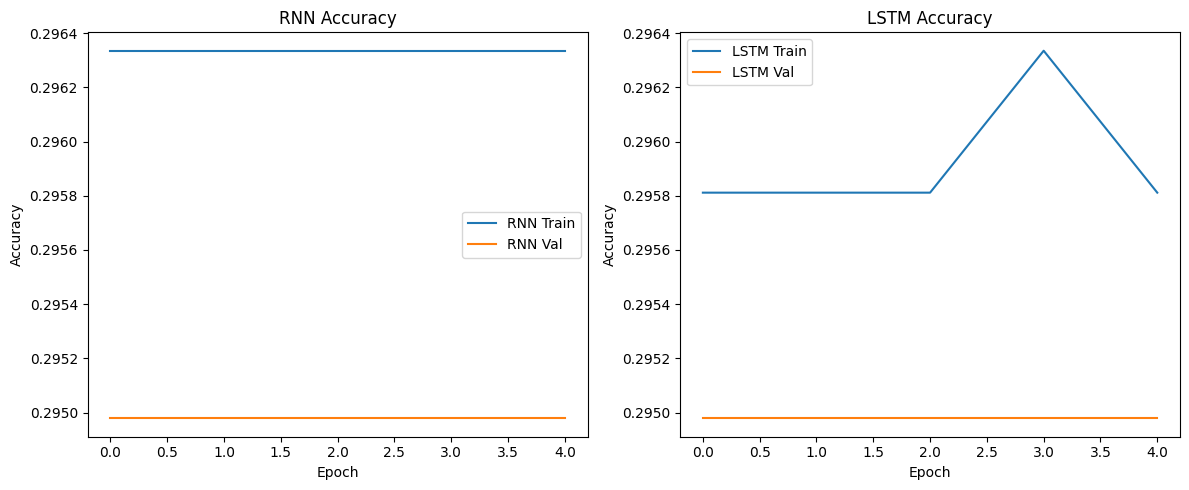

In [58]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_rnn.history['accuracy'], label='RNN Train')
plt.plot(history_rnn.history['val_accuracy'], label='RNN Val')
plt.title('RNN Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_lstm.history['accuracy'], label='LSTM Train')
plt.plot(history_lstm.history['val_accuracy'], label='LSTM Val')
plt.title('LSTM Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()